In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

from torchsummary import summary

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to match resnet default input size
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [5]:
class CustomMNISTDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        # convert labels <5 -> True, else -> False
        label = 1 if label < 5 else 0
        return image, label

In [6]:
from torch.utils.data import Subset
import numpy as np
# Define the size of the smaller dataset
subset_size = 500

# Generate random indices for the subset
train_indices = np.random.choice(len(train_dataset), subset_size, replace=False)
test_indices = np.random.choice(len(test_dataset), subset_size, replace=False)

# Create the smaller datasets using the Subset utility
train_dataset = Subset(train_dataset, train_indices)
test_dataset = Subset(test_dataset, test_indices)


train_custom_dataset = CustomMNISTDataset(train_dataset)
test_custom_dataset = CustomMNISTDataset(test_dataset)

In [7]:
from torchvision.models.resnet import ResNet18_Weights
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# modify resnet18 for 1 input channel and binary classification
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),  # output one value
    nn.Sigmoid()
)
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [8]:
# define data loaders, loss and optimizer
train_loader = DataLoader(train_custom_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_custom_dataset, batch_size=32, shuffle=False)

criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs=5
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )

In [9]:
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, f1_score

def accuracy(predicted_probs, reference):
    """
    Compute the accuracy for binary classification.

    @param predicted_logits: float32 tensor of shape (batch size, 1) representing raw model outputs (logits).
    @param reference: int64 tensor of shape (batch size,) with the binary class labels (0 or 1).
    """
    # Convert probabilities to binary predictions (0 or 1)
    predicted_labels = (predicted_probs > 0.5).float().squeeze()
    
    # Convert tensors to numpy arrays for compatibility with sklearn metrics
    predicted_labels_np = predicted_labels.cpu().numpy()
    reference_np = reference.cpu().numpy()

    # Calculate precision, recall, and F1 score
    precision = precision_score(reference_np, predicted_labels_np, zero_division=0)
    f1 = f1_score(reference_np, predicted_labels_np, zero_division=0)

    return precision, f1


def train(model, train_loader, test_loader, optimizer, scheduler, criterion, device, n_epochs=1):
    device = torch.device(device)
    model.to(device)
    print(f"training on device '{device}'")

    losses = []

    for epoch in range(n_epochs):
        model.train()
        with tqdm(train_loader, unit='batch') as tepoch:
            for x_batch, y_batch in tepoch :
                tepoch.set_description(f'Epoch {epoch}')

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(x_batch).squeeze()
                y_batch = y_batch.float()

                loss = criterion(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                tepoch.set_postfix(loss=loss.item())
               
                losses.append(loss.item())
                
        # evaluate on test set
        model.eval()
        accuracies_test = []
        f1_test = []
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            with torch.no_grad():
                prediction = model(batch_x)
                acc, f1 = accuracy(prediction, batch_y)
                accuracies_test.append(acc)
                f1_test.append(f1)

        print(
            "Epoch {} | Test accuracy: {:.5f}, f1: {:.5f}".format(
                epoch, sum(accuracies_test).item() / len(accuracies_test),
                sum(f1_test).item() / len(f1_test)
            )
        )
    
    plot_losses(losses)

def plot_losses(losses):
    plt.plot(losses, label='train')
    plt.title("loss")
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()

training on device 'mps'


  0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 0 | Test accuracy: 0.82003, f1: 0.76409


  0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 1 | Test accuracy: 0.92879, f1: 0.91683


  0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 2 | Test accuracy: 0.88225, f1: 0.92123


  0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 3 | Test accuracy: 0.93868, f1: 0.94583


  0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 4 | Test accuracy: 0.94953, f1: 0.94788


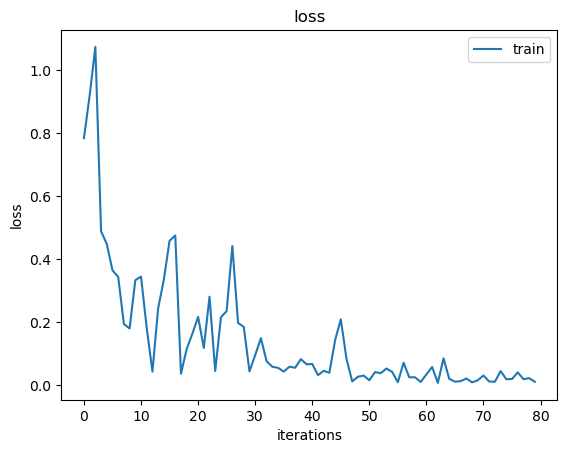

In [10]:
train(model, train_loader, test_loader, optimizer, scheduler, criterion, device, n_epochs=5)